# Import Libraries

In [1]:
import math
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from math import sqrt
from pandas import concat
from matplotlib import pyplot
from keras.models import Sequential
from numpy import concatenate, asarray
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# ---------- Retrieve Data -----------

In [2]:
# read file
data = pd.read_excel('data.xlsx')
data

,Ngày,Giá Cà Phê,Giá Diesel 1 lít,Precipitation (mm)
0,2021-01-01,31667.5,12640,1174.199994
1,2021-01-02,31667.5,12640,1174.199994
2,2021-01-03,31667.5,12640,1174.199994
3,2021-01-04,32717.0,12640,1174.199994
4,2021-01-05,32417.0,12640,1174.199994
...,...,...,...,...
824,2023-04-06,49766.5,20140,1259.800013
825,2023-04-07,49566.5,20140,1259.800013
826,2023-04-08,49566.5,20140,1259.800013
827,2023-04-09,49566.5,20140,1259.800013


In [3]:
# # drop
# data.drop(data.columns[[-1, -2]], axis=1, inplace=True)
# data

# --------- Normalization ----------

In [4]:
# drop date column
data.drop(data.columns[[0]], axis=1, inplace=True)

In [5]:
# convert series to supervised learning

def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
# set number of days
look_back = 60
predict_ahead = 30

# frame as supervised learning
reframed = series_to_supervised(data.values, look_back, predict_ahead)

In [7]:
# calculate total column to keep
data_column = len(data.columns)
keep_column = look_back * data_column
var_index = (look_back * data_column) + ((predict_ahead - 1) * data_column)

# drop unnecessary columns
reframed = reframed.drop(reframed.iloc[:, keep_column:var_index], axis = 1)
index_drop = (data_column - 1 ) * -1
reframed = reframed.drop(columns=reframed.columns[index_drop:], axis = 1)

dataset = reframed

In [8]:
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(reframed)
scaled.shape

(740, 181)

# ---------- Split data ----------

In [9]:
dataset = scaled

# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

592 148


In [10]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(592, 1, 180) (592,) (148, 1, 180) (148,)


# ---------- Train Model ----------

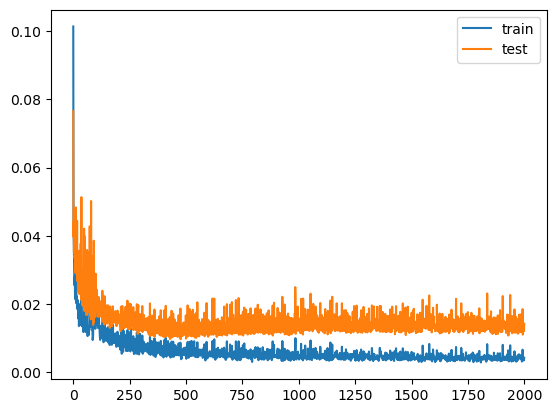

In [11]:
# design network
model = Sequential()
model.add(LSTM(8, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=2000, batch_size=32, 
                    validation_data=(test_X, test_y), verbose=False, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# (8, 32)

# ---------- Predict & Results Analysis ----------

In [12]:
# calculate metrics
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = sklearn.metrics.mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

def print_metrics(test, pre_test):
    
    testScore = np.sqrt(mean_squared_error(test,pre_test))
    print('RMSE: %.2f (đồng)' % (testScore))
    
    testScore = sklearn.metrics.mean_absolute_error(test, pre_test)
    print('\nMAE: %.2f (đồng)' % (testScore))
                            
    testScore = sklearn.metrics.mean_absolute_percentage_error(test, pre_test)
    print('\nMAPE: %.2f' % (testScore))
    
    testScore = mean_absolute_scaled_error(test, pre_test, test)
    print('\nMASE: %.2f' % (testScore))

In [13]:
# make a prediction
test_pred = (model.predict(test_X))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

5/5 [==============================] - 0s 1ms/step


In [14]:
# invert scaling for forecast
inv_test_pred = concatenate((test_pred, test_X), axis=1)
inv_test_pred = scaler.inverse_transform(inv_test_pred)
inv_test_pred = inv_test_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [15]:
# print results
print_metrics(inv_y, inv_test_pred)

RMSE: 2189.62 (đồng)

MAE: 1555.34 (đồng)

MAPE: 0.03

MASE: 8.93
